# Get the data

In [6]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
import warnings
sns.set()
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv', parse_dates=['pickup_datetime'])# `parse_dates` will recognize the column is date time
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv', parse_dates=['pickup_datetime'])
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [8]:
for df in (data,test):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hr']    = df['pickup_datetime'].dt.hour
    df['minute']= df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [9]:
test.head(3)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,day,hr,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,30,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,30,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,30,23,59


In [10]:
data = data.assign(log_trip_duration = np.log(data.trip_duration+1))

# Features

## 1.1 Pickup Time and Weekend Features

In [11]:
from datetime import datetime
holiday = pd.read_csv('../input/nyc2016holidays/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [12]:
holidays

[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 12),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 11, 8)]

In [13]:
time_data = pd.DataFrame(index = range(len(data)))
time_test = pd.DataFrame(index = range(len(test)))

In [14]:
from datetime import date
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [15]:
rest_day,weekend = restday(data.year,data.month,data.day,holidays)
time_data = time_data.assign(rest_day=rest_day)
time_data = time_data.assign(weekend=weekend)

rest_day,weekend = restday(test.year,test.month,test.day,holidays)
time_test = time_test.assign(rest_day=rest_day)
time_test = time_test.assign(weekend=weekend)

In [16]:
time_data = time_data.assign(pickup_time = data.hr+data.minute/60)#float value. E.g. 7.5 means 7:30 am
time_test = time_test.assign(pickup_time = test.hr+test.minute/60)

In [17]:
time_data.head()


,rest_day,weekend,pickup_time
0,False,False,17.400000
1,True,True,0.716667
2,False,False,11.583333
3,False,False,19.533333
4,True,True,13.500000


## 1.2 Distance Features

In [18]:
fastrout1 = pd.read_csv('../input/newyorkcitytaxiwithosrm/fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout2 = pd.read_csv('../input/newyorkcitytaxiwithosrm/fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


In [19]:
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))
right_turn[:3]

[1, 2, 1]

In [20]:
osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2


In [21]:
data = data.join(osrm_data.set_index('id'), on='id')
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hr,minute,log_trip_duration,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016,3,14,17,24,6.122493,2009.1,164.9,5.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016,6,12,0,43,6.498282,2513.2,332.0,6.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016,1,19,11,35,7.661527,11060.8,767.6,16.0,5.0,4.0


In [22]:
osrm_test = pd.read_csv('../input/newyorkcitytaxiwithosrm/fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4


In [23]:
test = test.join(osrm_test.set_index('id'), on='id')


In [24]:
osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4
3,id3684027,931.8,84.2,4,2,1
4,id3101285,2501.7,294.7,8,3,3


In [25]:
osrm_data = data[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = test[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

## 1.3 Location Features: K-means Clustering

In [26]:
coord_pickup = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,                  
                          test[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((data[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

In [27]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (data,test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

In [28]:
kmean10_data = data[['pickup_dropoff_loc']]
kmean10_test = test[['pickup_dropoff_loc']]

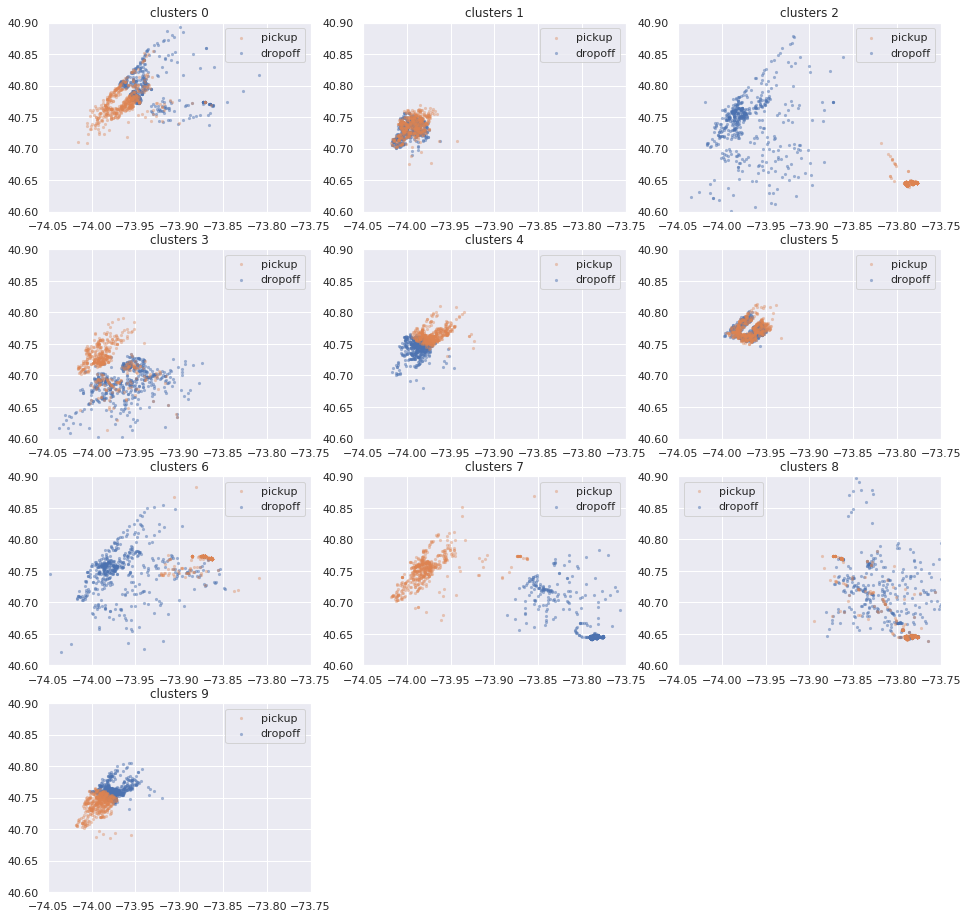

In [29]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = data[data.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)

## 1.4 Weather Features

In [30]:
weather = pd.read_csv('../input/knycmetars2016/KNYC_Metars.csv', parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


In [31]:
print('The Events has values {}.'.format(str(set(weather.Events))))

The Events has values {'Fog\n\t,\nSnow', 'Fog', 'Rain', 'Fog\n\t,\nRain', 'Snow', 'None'}.


In [32]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]

In [33]:
weather.head()

,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [34]:
data = pd.merge(data, weather, on = ['month', 'day', 'hr'], how = 'left')
test = pd.merge(test, weather, on = ['month', 'day', 'hr'], how = 'left')

In [35]:
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hr,minute,log_trip_duration,total_distance,total_travel_time,number_of_steps,right_steps,left_steps,pickup_dropoff_loc,Temp.,Precip,snow,Visibility
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016,3,14,17,24,6.122493,2009.1,164.9,5.0,1.0,1.0,5,4.4,0.3,0.0,8.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016,6,12,0,43,6.498282,2513.2,332.0,6.0,2.0,2.0,1,28.9,0.0,0.0,16.1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016,1,19,11,35,7.661527,11060.8,767.6,16.0,5.0,4.0,1,-6.7,0.0,0.0,16.1


In [36]:
weather_data = data[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]

In [37]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,4.4,0.3,0.0,8.0
1,28.9,0.0,0.0,16.1
2,-6.7,0.0,0.0,16.1
3,7.2,0.0,0.0,16.1
4,9.4,0.0,0.0,16.1


# 2. Outliers

In [38]:
outliers=np.array([False]*len(data))

In [39]:
print('There are %d rows that have missing values'%sum(data.isnull().any(axis=1)))

There are 56598 rows that have missing values


## 2.1 Outliers from 'trip_duration'¶


Text(0, 0.5, 'frequency')

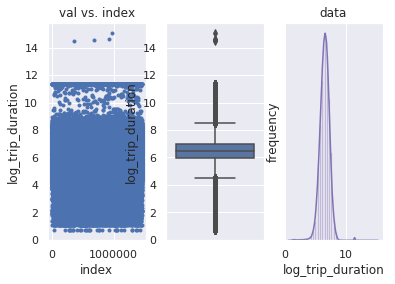

In [40]:
y = np.array(data.log_trip_duration)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('log_trip_duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=data.log_trip_duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('log_trip_duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

In [41]:
outliers[y>12]=True
print('There are %d entries that have trip duration too long'% sum(outliers))

There are 4 entries that have trip duration too long


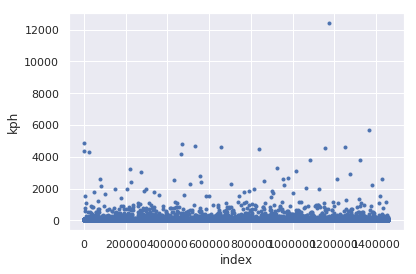

In [42]:
kph = osrm_data.total_distance/1000/data.trip_duration*3600
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

In [43]:
kph = np.array(kph)
kph[np.isnan(kph)]=0.0
dist = np.array(osrm_data.total_distance) #note this is in meters
dist[np.isnan(dist)]=0.0
outliers_speeding = np.array([False]*len(kph))
outliers_speeding = outliers_speeding | ((kph>300) & (dist>1000))
outliers_speeding = outliers_speeding | ((kph>180)  & (dist<=1000))                                         
outliers_speeding = outliers_speeding | ((kph>100)  & (dist<=100))                                         
outliers_speeding = outliers_speeding | ((kph>80)  & (dist<=20))
print('There are %d speeding outliers'%sum(outliers_speeding))   
outliers = outliers|outliers_speeding

There are 534 speeding outliers


## 2.2 Outliers from Locations

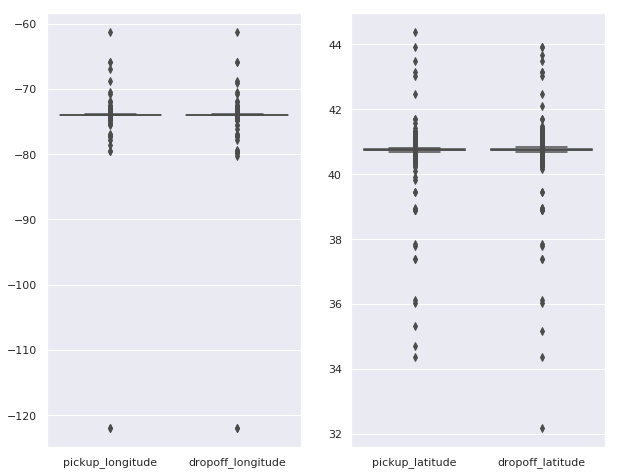

In [44]:
fig=plt.figure(figsize=(10, 8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    plt.subplot(1,2,i+1)
    sns.boxplot(data=data[outliers==False],order=loc);#plt.title(loc)

In [45]:
outliers[data.pickup_longitude<-110]=True
outliers[data.dropoff_longitude<-110]=True
outliers[data.pickup_latitude>45]=True
print('There are total %d entries of ouliers'% sum(outliers))

There are total 540 entries of ouliers


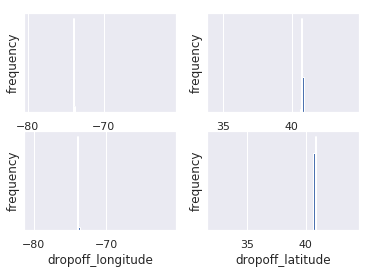

In [46]:
for i,feature in enumerate(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']):
    plt.subplot(2,2,i+1)
    data[outliers==False][feature].hist(bins=100)
    plt.xlabel(feature);plt.ylabel('frequency');plt.yticks([])
#plt.show();plt.close()

In [47]:
import folium # goelogical map
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)
#tile: 'OpenStreetMap','Stamen Terrain','Mapbox Bright','Mapbox Control room'
for each in data[:1000].iterrows():
    folium.CircleMarker([each[1]['pickup_latitude'],each[1]['pickup_longitude']],
                        radius=3,
                        color='red',
                        popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(map_1)
map_1

In [48]:
Out = pd.DataFrame()
Out = Out.assign(outliers=outliers)

In [49]:
data = data.assign(outliers=outliers)

# 3. Analysis of Features

In [50]:
tmpdata = data
tmpdata = pd.concat([tmpdata,time_data],axis = 1)
tmpdata = tmpdata[outliers==False]

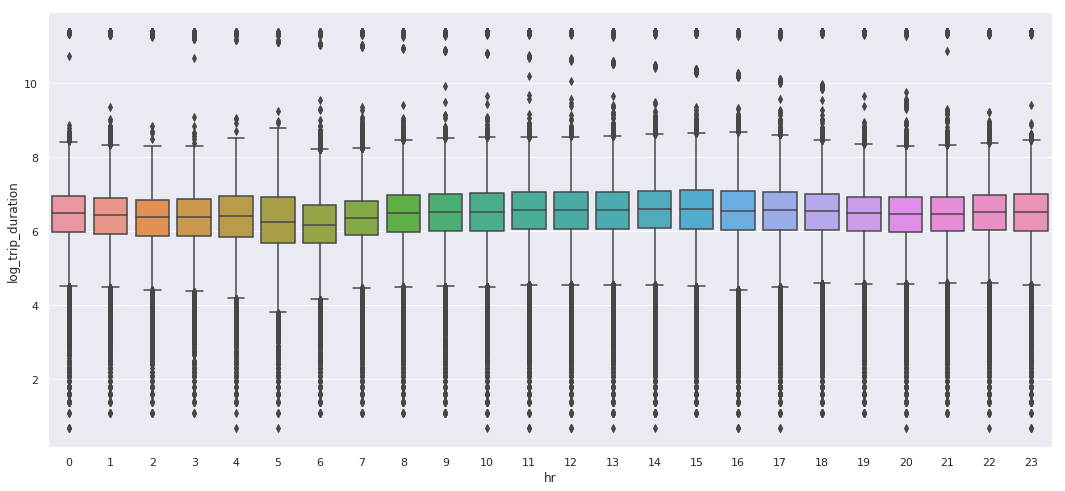

In [51]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="hr", y="log_trip_duration", data=tmpdata)

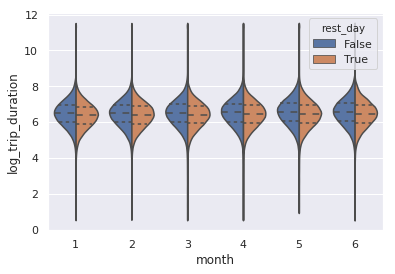

In [52]:
sns.violinplot(x="month", y="log_trip_duration", hue="rest_day", data=tmpdata, split=True,inner="quart")

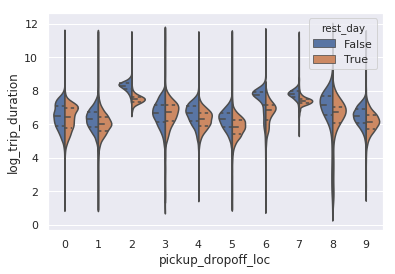

In [53]:
sns.violinplot(x="pickup_dropoff_loc", y="log_trip_duration",
               hue="rest_day", 
               data=tmpdata[np.array(tmpdata.pickup_time>7) & np.array(tmpdata.pickup_time<9)], 
               split=True,inner="quart")

# 4. XGB Model: the Prediction of trip_duration

In [54]:
mydf = data[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

testdf = test[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

In [55]:
mydf.head(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0


In [56]:
kmean_data= pd.get_dummies(kmean10_data.pickup_dropoff_loc,prefix='loc', prefix_sep='_')    
kmean_test= pd.get_dummies(kmean10_test.pickup_dropoff_loc,prefix='loc', prefix_sep='_')    

In [57]:
kmean10_data.head(3)

,pickup_dropoff_loc
0,5
1,1
2,1


In [58]:
kmean_data.head(3)

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9
0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0


In [59]:
mydf  = pd.concat([mydf  ,time_data,weather_data,osrm_data,kmean_data],axis=1)
testdf= pd.concat([testdf,time_test,weather_test,osrm_test,kmean_test],axis=1)

In [60]:
if np.all(mydf.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature')
else:
    print('Oops, something is wrong, keys in training and testing are not matching')

Good! The keys of training feature is identical to those of test feature


In [61]:
mydf['rest_day']=1*(mydf['rest_day']==True)
mydf['weekend']=1*(mydf['weekend']==True)

In [62]:
X = mydf[Out.outliers==False]
z = data[Out.outliers==False].log_trip_duration.values

In [63]:
if np.all(X.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature.')
    print('They both have %d features, as follows:'%len(X.keys()))
    print(list(X.keys()))
else:
    print('Oops, something is wrong, keys in training and testing are not matching')

Good! The keys of training feature is identical to those of test feature.
They both have 29 features, as follows:
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'rest_day', 'weekend', 'pickup_time', 'Temp.', 'Precip', 'snow', 'Visibility', 'total_distance', 'total_travel_time', 'number_of_steps', 'right_steps', 'left_steps', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9']


In [64]:
import xgboost as xgb


In [66]:
from sklearn.model_selection import train_test_split

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval  , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [67]:
Xtrain.head(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,rest_day,weekend,pickup_time,Temp.,Precip,snow,Visibility,total_distance,total_travel_time,number_of_steps,right_steps,left_steps,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9
432418,2,1,-73.974808,40.756638,-73.886742,40.766945,0,1,1,18.316667,19.4,0.0,0.0,16.1,9810.9,716.8,15.0,4.0,3.0,1,0,0,0,0,0,0,0,0,0
533321,2,1,-73.984756,40.724392,-73.988708,40.748398,0,1,1,4.066667,20.0,0.0,0.0,11.3,3634.1,501.8,6.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0


In [68]:
Xval.shape

(291621, 29)

In [69]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()
n_inputs=29
n_hidden1=30
n_hidden2=15
n_hidden3=7
n_outputs=1

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.float32, shape=(None), name="y")
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")
hidden2= tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                        kernel_initializer=he_init, name="hidden2")
hidden3= tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                        kernel_initializer=he_init, name="hidden3")
output = tf.layers.dense(hidden3, n_outputs, kernel_initializer=he_init, name="outputs")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [70]:
learning_rate=0.01
mse = tf.losses.mean_squared_error(labels=y, predictions=output)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(mse, name="training_op")


init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [72]:
n_epochs = 100
batch_size = 100

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(Xtrain))
        for rnd_indices in np.array_split(rnd_idx, len(Xtrain) // batch_size):
            X_batch, y_batch = Xtrain.iloc[rnd_indices], Ztrain[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = sess.run(mse, feed_dict={X: Xval, y: Zval})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./mymodel.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\t".format(
            epoch, loss_val, best_loss ))

ResourceExhaustedError: OOM when allocating tensor with shape[291621,291621] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-70-36e68d73e4b5>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'mean_squared_error/SquaredDifference', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-36e68d73e4b5>", line 2, in <module>
    mse = tf.losses.mean_squared_error(labels=y, predictions=output)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py", line 670, in mean_squared_error
    losses = math_ops.squared_difference(predictions, labels)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 9467, in squared_difference
    "SquaredDifference", x=x, y=y, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[291621,291621] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-70-36e68d73e4b5>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
"""parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))"""

## submission

In [ ]:
"""data_test = xgb.DMatrix(testdf)
ztest = model.predict(data_test)
ytest = np.exp(ztest)-1
print(ytest[:10])
submission = pd.DataFrame({'id': test.id, 'trip_duration': ytest})
submission.to_csv('submission.csv', index=False)"""